# <b>Прогнозирование температуры звезды<b>
    
Вам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Обычно для расчёта температуры учёные пользуются следующими методами:

- Закон смещения Вина.

- Закон Стефана-Больцмана.

- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

В базе обсерватории есть характеристики уже изученных 240 звёзд.


## Характеристики

- Относительная светимость `L/Lo` — светимость звезды относительно Солнца.

- Относительный радиус `R/Ro` — радиус звезды относительно радиуса Солнца.

- Абсолютная звёздная величина `Mv` — физическая величина, характеризующая блеск звезды.

- Звёздный цвет (`white`, `red`, `blue`, `yellow`, `yellow-orange` и др.) — цвет звезды, который определяют на основе спектрального анализа.

- Тип звезды:

    * Коричневый карлик → `0`
    * Красный карлик → `1`
    * Белый карлик → `2`
    * Звёзды главной последовательности → `3`
    * Сверхгигант → `4`
    * Гипергигант → `5`

- Абсолютная температура `T(K)` — температура на поверхности звезды в Кельвинах.

В этом самостоятельном проекте вам необходимо разработать нейронную сеть, которая поможет предсказывать абсолютную температуру на поверхности звезды.

### Шаг 0. Подключаем необходимые модули

In [1]:
import random
import math
import time
from math import ceil

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim
from torchmetrics import MeanSquaredError

Проверим устройство, на котором будем производить вычисления:

In [52]:
if torch.cuda.is_available():  
  dev = "cuda:0"
else:
  dev = "cpu"

DEVICE = torch.device(dev)
print(f'Device is: {str(DEVICE).upper()}\n')

Device is: CPU



## Алгоритм решения задачи

### Шаг 1. Загрузка исходных данных из файла

In [53]:
df = pd.read_csv('...')
display(df.head())

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


In [54]:
# Приводим имена столбцов к нижнему регистру, переименовываем
df.rename(columns={'Temperature (K)': 'temperature',
                   'Luminosity(L/Lo)': 'luminosity',
                   'Radius(R/Ro)': 'radius',
                   'Absolute magnitude(Mv)': 'absolute_magnitude',
                   'Star type': 'star_type',
                   'Star color': 'star_color'}, inplace=True)

# Удаляем столбец "Unnamed: 0" как бесполезный - это всего лишь номер по порядку
df.drop('Unnamed: 0', axis=1, inplace=True)
display(df.head())
print()
print('Смотрим общую информацию по набору данных:')
print()
display(df.info())

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red



Смотрим общую информацию по набору данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   temperature         240 non-null    int64  
 1   luminosity          240 non-null    float64
 2   radius              240 non-null    float64
 3   absolute_magnitude  240 non-null    float64
 4   star_type           240 non-null    int64  
 5   star_color          240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


None

Видим, что пропусков в наборе данных нет, каждый из столбцов содержит 240 ненулевых значений.

Заодно проверим, нет ли в нашем наборе данных явных дубликатов:

In [55]:
print(f'Количество явных дублей: {df.duplicated().sum()}')

Количество явных дублей: 0


### Шаг 2. Исследовательский анализ

#### Шаг 2.1 Проведите исследовательский анализ <u>количественных данных</u>.

К количественным данным относятся признаки:

- `temperature`;

- `luminosity`;

- `radius`;

- `absolute_magnitude`.

##### <b>2.1.1 Анализ признака `temperature`</b>

In [56]:
df[['temperature']].describe()

,temperature
count,240.000000
mean,10497.462500
std,9552.425037
min,1939.000000
25%,3344.250000
50%,5776.000000
75%,15055.500000
max,40000.000000


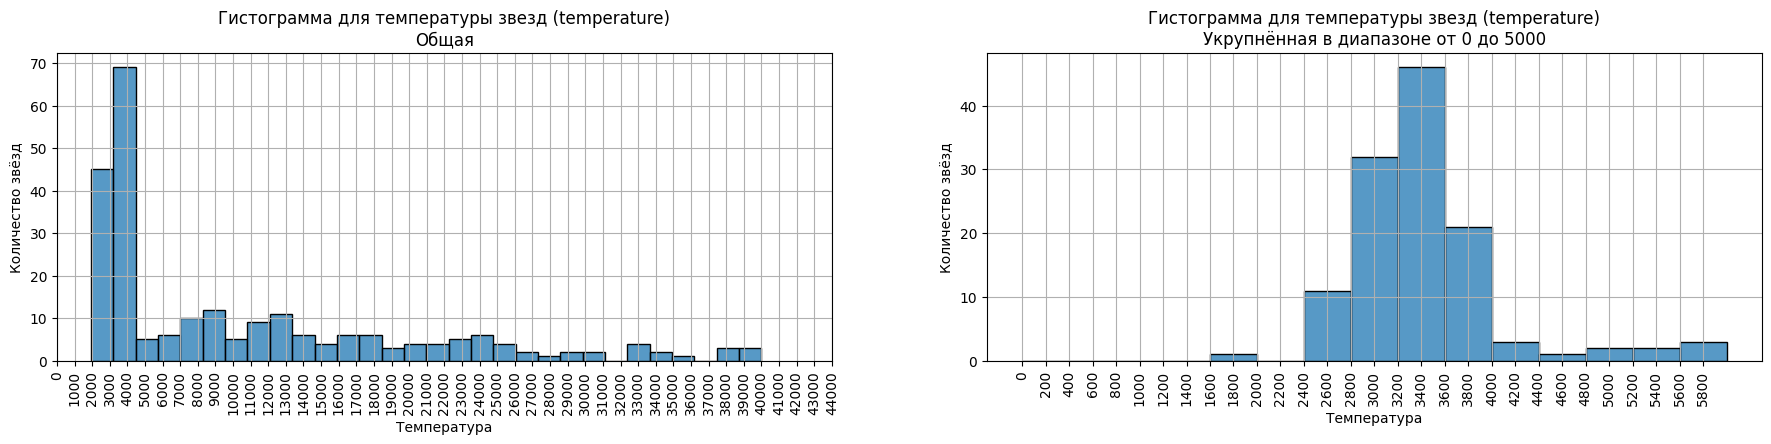

In [57]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22, 4))
_ = sns.histplot(data=df, x='temperature', bins=30, ax=axs[0])
_ = axs[0].set_xticks(range(0, 45000, 1000))
_ = axs[0].xaxis.set_tick_params(rotation=90)
_ = axs[0].set_xlabel('Температура')
_ = axs[0].set_ylabel('Количество звёзд')
_ = axs[0].set_title('Гистограмма для температуры звезд (temperature)\nОбщая')
_ = axs[0].grid(True)

_ = sns.histplot(data=df, x='temperature', binrange=(0, 6000), bins=15, ax=axs[1])
_ = axs[1].set_xticks(range(0, 6000, 200))
_ = axs[1].xaxis.set_tick_params(rotation=90)
_ = axs[1].set_xlabel('Температура')
_ = axs[1].set_ylabel('Количество звёзд')
_ = axs[1].set_title('Гистограмма для температуры звезд (temperature)\nУкрупнённая в диапазоне от 0 до 5000')
_ = axs[1].grid(True)

<u>Вывод по признаку `temperature`:</u>

Явных выбросов не наблюдается, минимальное (`1939 K`) и максимальное (`40000 K`) значения в пределах допустимых значений. Из правой гистограммы можно увидеть, что мода распределения находится в районе `3400 K`, это порядка `40` звезд (холодные звезды, судя по температуре). Отметим также скошенность распределения вправо с длинным правым хвостом. На каждую `1000 К` приходится не так много звёзд, но достаточно для того, чтобы среднее значение (`10497 K`) оказалось почти вдвоё больше медианы (`5776 K`).

----------------------

##### <b>2.1.2 Анализ признака `luminosity`</b>

In [58]:
df[['luminosity']].describe()

,luminosity
count,240.000000
mean,107188.361635
std,179432.244940
min,0.000080
25%,0.000865
50%,0.070500
75%,198050.000000
max,849420.000000


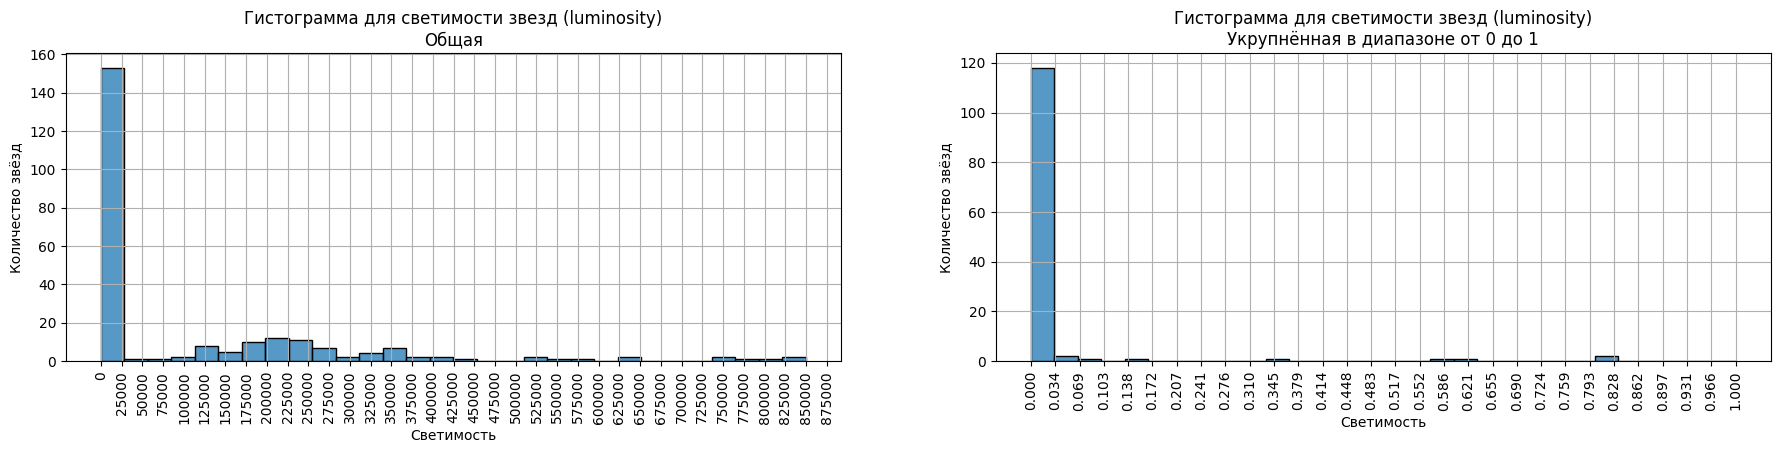

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22, 4))
_ = sns.histplot(data=df, x='luminosity', bins=30, ax=axs[0])
_ = axs[0].set_xticks(range(0, 880000, 25000))
_ = axs[0].xaxis.set_tick_params(rotation=90)
_ = axs[0].set_xlabel('Светимость')
_ = axs[0].set_ylabel('Количество звёзд')
_ = axs[0].set_title('Гистограмма для светимости звезд (luminosity)\nОбщая')
_ = axs[0].grid(True)

_ = sns.histplot(data=df, x='luminosity', binrange=(0, 1), bins=30, ax=axs[1])
_ = axs[1].set_xticks(np.linspace(0, 1, 30))
_ = axs[1].xaxis.set_tick_params(rotation=90)
_ = axs[1].set_xlabel('Светимость')
_ = axs[1].set_ylabel('Количество звёзд')
_ = axs[1].set_title('Гистограмма для светимости звезд (luminosity)\nУкрупнённая в диапазоне от 0 до 1')
_ = axs[1].grid(True)

<u>Вывод по признаку `luminosity`:</u>

На первый взгляд может показаться, что со значениями данного признака есть проблема (указана не относительная, а абсолютная светимость): мода распределения на левой гистограмме чуть больше `0` (таких звёзд почти `120`), в то время как максимум распределения равен `849420`.

Тем не менее, осмелися предположить, что здесь всё же нет ошибки - относительная светимость может быть и много больше, и много меньше относительно светимости солнца:

    "Известны звезды, излучающие в десятки тысяч раз меньше, чем Солнце. А звезда S Золотой Рыбы, видимая только в странах южного полушария Земли как звездочка 8-й звездной величины (не видимая невооруженным глазом!), в миллион раз ярче Солнца"
    
----------------------

##### <b>2.1.3 Анализ признака `radius`</b>

In [60]:
df[['radius']].describe()

,radius
count,240.000000
mean,237.157781
std,517.155763
min,0.008400
25%,0.102750
50%,0.762500
75%,42.750000
max,1948.500000


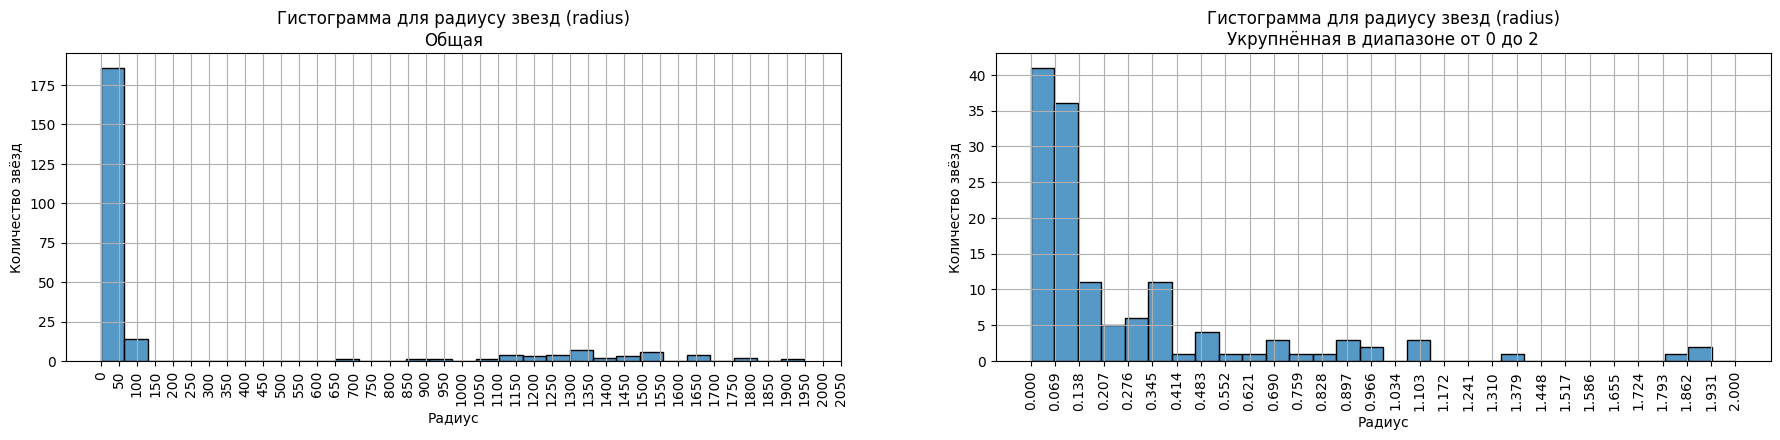

In [61]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(22, 4))
_ = sns.histplot(data=df, x='radius', bins=30, ax=axs[0])
_ = axs[0].set_xticks(range(0, 2100, 50))
_ = axs[0].xaxis.set_tick_params(rotation=90)
_ = axs[0].set_xlabel('Радиус')
_ = axs[0].set_ylabel('Количество звёзд')
_ = axs[0].set_title('Гистограмма для радиусу звезд (radius)\nОбщая')
_ = axs[0].grid(True)

_ = sns.histplot(data=df, x='radius', binrange=(0, 2), bins=30, ax=axs[1])
_ = axs[1].set_xticks(np.linspace(0, 2, 30))
_ = axs[1].xaxis.set_tick_params(rotation=90)
_ = axs[1].set_xlabel('Радиус')
_ = axs[1].set_ylabel('Количество звёзд')
_ = axs[1].set_title('Гистограмма для радиусу звезд (radius)\nУкрупнённая в диапазоне от 0 до 2')
_ = axs[1].grid(True)

<u>Вывод по признаку `radius`:</u>

Минимальное значение распределения равно `0.008400`, примерно такое же значение у моды - большинство звёзд из набора данных значительно меньше Солнца по радиусу, и судя по всему, этому [можно верить](https://wikipredia.net/ru/List_of_smallest_stars).
Максимум равен `1948`, что также [выглядит правдоподобным](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%BA%D1%80%D1%83%D0%BF%D0%BD%D0%B5%D0%B9%D1%88%D0%B8%D1%85_%D0%B7%D0%B2%D1%91%D0%B7%D0%B4) (к примеру, радиус звезды "_Stephenson 2-18_" составляет `2150` радиусов Солнца).
Распределение своей скошенностью вправо напоминает предыдущие, разве что можно отметить малое количество звезд с радиусом от 150 до 650 радиусов Солнца.

----------------------

##### <b>2.1.3 Анализ признака `absolute_magnitude`</b>

In [62]:
df[['absolute_magnitude']].describe()

,absolute_magnitude
count,240.000000
mean,4.382396
std,10.532512
min,-11.920000
25%,-6.232500
50%,8.313000
75%,13.697500
max,20.060000


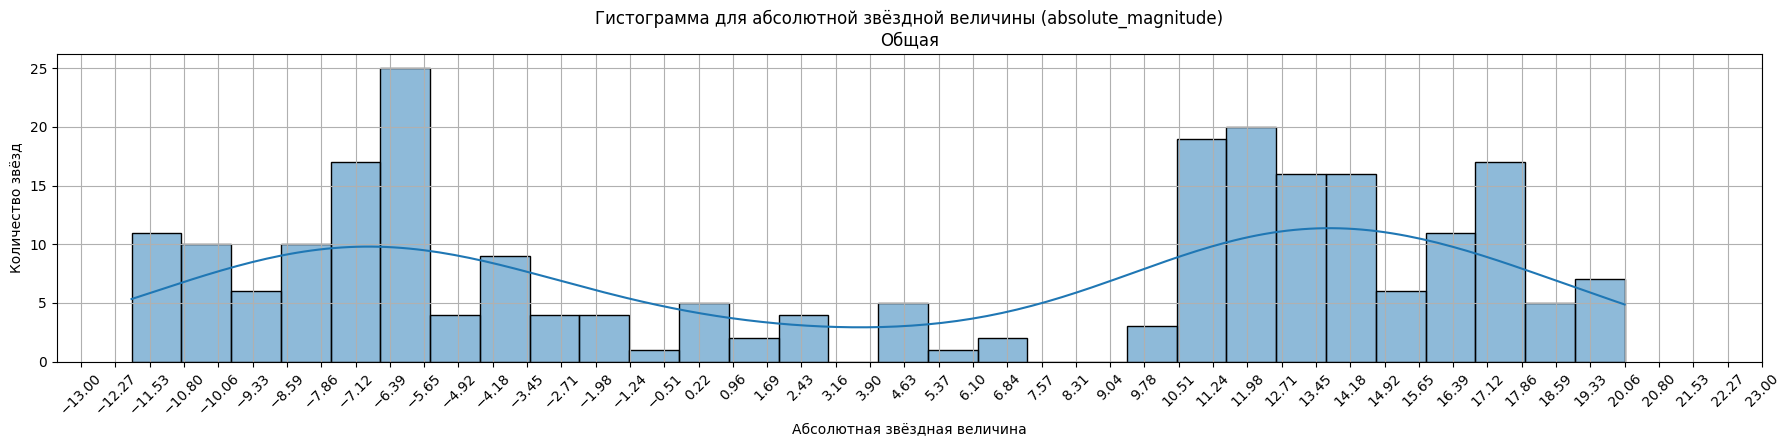

In [63]:
fig, ax = plt.subplots(figsize=(22, 4))
_ = sns.histplot(data=df, x='absolute_magnitude', bins=30, kde=True, ax=ax)
_ = ax.set_xticks(np.linspace(-13, 23, 50))
_ = ax.xaxis.set_tick_params(rotation=45)
_ = ax.set_xlabel('Абсолютная звёздная величина')
_ = ax.set_ylabel('Количество звёзд')
_ = ax.set_title('Гистограмма для абсолютной звёздной величины (absolute_magnitude)\nОбщая')
_ = ax.grid(True)

<u>Вывод по признаку `absolute_magnitude`:</u>

Первое, что здесь сразу бросается в глаза, это отрицательные значения абсолютной звездной величины. Однако, судя по всему, этому [есть объяснение](https://spacegid.com/zvezdnaya-velichina.html):

    "Вега с нулевым блеском (0m) не самая яркая звезда на небосводе (пятая по блеску, третья для наблюдателей с территории СНГ). Поэтому более яркие звезды могут иметь отрицательную звездную величину, к примеру, Сириус (-1.5m)"
    
Само распределение своим видом похоже на бимодальное, со всплеском количества звёзд со значениями звёздной величины около `-6` и около `+14`. Отметим также, что все значения, в том числе минимальное и максимальное, здесь весьма близки между собой - распределение не выглядит широким.

#### Шаг 2.2 Проведите исследовательский анализ <u>категориальных данных</u>.

##### <b>2.2.1 Анализ признака `star_type`</b>

In [64]:
df['star_type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: star_type, dtype: int64

Раз уж нам были предоставлены расшифровки каждого из типа звёзд, выполним переименование, уйдя от численного представления (семантика данного столбца выглядит категориальной даже несмотря на численное представление значений в нём):

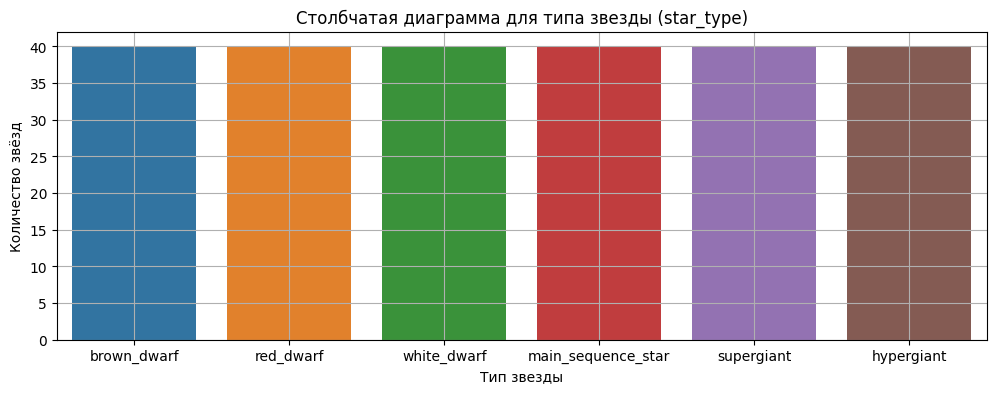

In [65]:
def set_star_type(star_type_id):
    if star_type_id == 0:
        return 'brown_dwarf'
    elif star_type_id == 1:
        return 'red_dwarf'
    elif star_type_id == 2:
        return 'white_dwarf'
    elif star_type_id == 3:
        return 'main_sequence_star'
    elif star_type_id == 4:
        return 'supergiant'
    elif star_type_id == 5:
        return 'hypergiant'
    else:
        raise ValueError('Unknown start type id provided.')

df['star_type'] = df['star_type'].apply(set_star_type)

fig, ax = plt.subplots(figsize=(12, 4))
_ = sns.countplot(data=df, x='star_type', ax=ax)
_ = ax.set_xlabel('Тип звезды')
_ = ax.set_ylabel('Количество звёзд')
_ = ax.set_title('Столбчатая диаграмма для типа звезды (star_type)')
_ = ax.grid(True)

<u>Вывод по признаку `star_type`:</u>

Видим что-то напоминающее дискретное равномерное распределение.

Отметим, что признаку скорее всего потребуется Ohe-Hot кодирование.

----------------------

##### <b>2.2.1 Анализ признака `star_color`</b>

In [66]:
display(df['star_color'].unique())
display(df['star_color'].value_counts())

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: star_color, dtype: int64

In [67]:
df['star_color'] = df['star_color'].apply(lambda x: x.lower()) # приводим всё к нижнему регистру
df['star_color'] = df['star_color'].apply(lambda x: x.replace('yellowish', 'yellow')) # вместо "желтоватый" будем рассматривать просто "желтый"
df['star_color'] = df['star_color'].apply(lambda x: x.replace('whitish', 'white')) # аналогично для "беловатый" -> "белый"
df['star_color'] = df['star_color'].apply(lambda x: x.replace('blue white', 'blue-white')) # отдадим предпочтение дефисному написанию
df['star_color'] = df['star_color'].apply(lambda x: x.replace('yellow white', 'yellow-white')) # отдадим предпочтение дефисному написанию
df['star_color'] = df['star_color'].apply(lambda x: x.replace('blue-white ', 'blue-white')) # удалим пробел в конце
df['star_color'] = df['star_color'].apply(lambda x: x.replace('blue ', 'blue-white')) # удалим пробел в конце

# Далее, согласно следующей таблице: https://bestdoubles.files.wordpress.com/2010/06/starcolors.jpg заменим ...
df['star_color'] = df['star_color'].apply(lambda x: x.replace('pale yellow orange', 'orange')) # ... "pale yellow orange" заменяем на "orange"
df['star_color'] = df['star_color'].apply(lambda x: x.replace('white-yellow', 'yellow')) # ... "white-yellow" заменяем на "yellow"
df['star_color'] = df['star_color'].apply(lambda x: x.replace('orange-red', 'red')) # ... "orange-red" заменяем на "red"

df['star_color'].value_counts()

red             113
blue             55
blue-white       42
white            12
yellow-white     11
yellow            4
orange            3
Name: star_color, dtype: int64

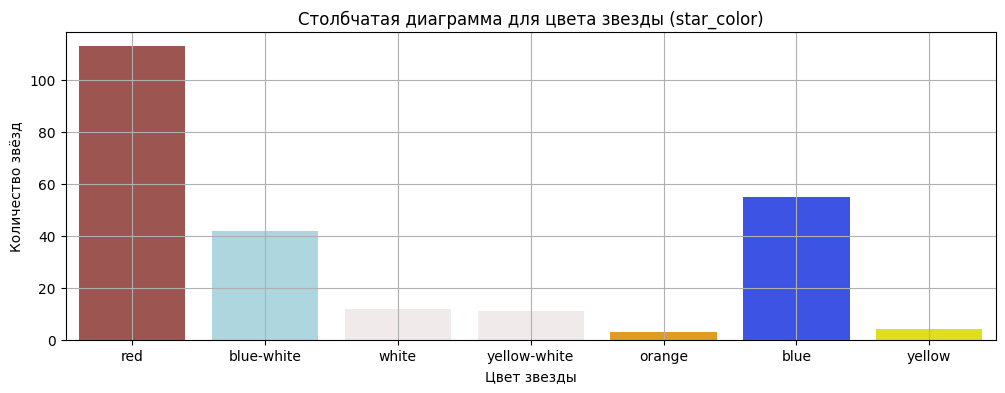

In [68]:
fig, ax = plt.subplots(figsize=(12, 4))
_ = sns.countplot(data=df, x='star_color', palette=['#AA4A44', '#A4DBE8', '#F2E9EA', '#F2E9EA', '#FFA500', '#213FFF', '#FFFF00'], ax=ax)
_ = ax.set_xlabel('Цвет звезды')
_ = ax.set_ylabel('Количество звёзд')
_ = ax.set_title('Столбчатая диаграмма для цвета звезды (star_color)')
_ = ax.grid(True)

<u>Вывод по признаку `star_color`:</u>

В лидерах звезды красного цвета (почти половина набора данных), на 2 и 3 месте бело-голубые и просто голубые звезды, эти 3 категории составляют `~87%` всех представленных звёзд. Данный столбец также потребует One-Hot кодировку как категориальный.

----------------------

### Шаг 3. Подготовка данных к построению модели

#### Шаг 3.1 По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.

Будем считать, что необходимые корректировки уже были сделаны, они касались приведения именования цвета звёзд (`star_color`) к "общему знаменателю" и замену некоторых редких (единичных) цветов на близкий и более частотный. Некоторую настороженность вызывает признак светимости, но в силу крайне ограниченного набора данных - всего 240 образцов - не похоже, что здесь стоит  проводить какую-то дополнительную очистку, связанную с удалением данных.

#### Шаг 3.2 Если необходимо, категоризируйте исходные данные.

Считаем, что в этом нет необходимости.

#### Шаг 3.3 Подготовьте обучающую и тестовую выборки.

Разделим наши данные на обучающую, валидационную и тренировочную выборки в пропорции `3:1:1`:

In [69]:
Xy_train, Xy_test_valid = train_test_split(df, train_size=0.8, random_state=1)
Xy_test, Xy_valid = train_test_split(Xy_test_valid, test_size=0.5, random_state=0)

Xy_train = Xy_train.reset_index(drop=True)
Xy_test  = Xy_test.reset_index(drop=True)
Xy_valid = Xy_valid.reset_index(drop=True)

print(df.shape)
print(Xy_train.shape, Xy_valid.shape, Xy_test.shape)

(240, 6)
(192, 6) (24, 6) (24, 6)


#### Шаг 3.4 Проведите масштабирование количественных данных.

Начнём с проведения One-Hot Encoding для признаков `star_type` и `star_color`:

In [70]:
ONE_HOT_ENCODER = OneHotEncoder(handle_unknown='ignore', sparse=False)
SCALER = StandardScaler()

def do_one_hot_encoding(df, one_hot_encoder, is_training):
    if is_training:
        df_transformed_cols = one_hot_encoder.fit_transform(df[['star_type', 'star_color']])
    else:
        df_transformed_cols = one_hot_encoder.transform(df[['star_type', 'star_color']])
        
    feature_names = one_hot_encoder.get_feature_names_out(['star_type', 'star_color'])
    df_encoded_cols = pd.DataFrame(df_transformed_cols, index=df.index, columns=feature_names)
    df_other_cols = df.drop(columns=['star_type', 'star_color'])
    df_encd = pd.concat([df_encoded_cols, df_other_cols], axis=1)
    return df_encd

def scale_numeric_features(X, scaler, is_training):
    cols_to_scale = ['luminosity', 'radius', 'absolute_magnitude']
    
    if is_training:
        scaler.fit(X[cols_to_scale])

    X[cols_to_scale] = scaler.transform(X[cols_to_scale])
    return X

display(Xy_train)

Xy_train = do_one_hot_encoding(Xy_train, ONE_HOT_ENCODER, is_training=True)
Xy_valid = do_one_hot_encoding(Xy_valid, ONE_HOT_ENCODER, is_training=False)
Xy_test  = do_one_hot_encoding(Xy_test,  ONE_HOT_ENCODER, is_training=False)

Xy_train = scale_numeric_features(Xy_train, SCALER, is_training=True)
Xy_valid = scale_numeric_features(Xy_valid, SCALER, is_training=False)
Xy_test  = scale_numeric_features(Xy_test, SCALER,  is_training=False)

display(Xy_train)

,temperature,luminosity,radius,absolute_magnitude,star_type,star_color
0,3068,0.002400,0.17000,16.12,brown_dwarf,red
1,3600,240000.000000,1190.00000,-7.89,hypergiant,red
2,3150,0.008800,0.35000,11.94,red_dwarf,red
3,3218,0.000452,0.09870,17.34,brown_dwarf,red
4,7723,0.000140,0.00878,14.81,white_dwarf,white
...,...,...,...,...,...,...
187,3598,0.001100,0.56000,14.26,red_dwarf,red
188,3304,0.008500,0.18000,13.20,red_dwarf,red
189,13420,0.000590,0.00981,13.67,white_dwarf,blue-white
190,38940,374830.000000,1356.00000,-9.93,hypergiant,blue


,star_type_brown_dwarf,star_type_hypergiant,star_type_main_sequence_star,star_type_red_dwarf,star_type_supergiant,star_type_white_dwarf,star_color_blue,star_color_blue-white,star_color_orange,star_color_red,star_color_white,star_color_yellow,star_color_yellow-white,temperature,luminosity,radius,absolute_magnitude
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3068,-0.587835,-0.443863,1.081587
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3600,0.778770,1.960813,-1.195534
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3150,-0.587835,-0.443499,0.685154
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3218,-0.587835,-0.444007,1.197292
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,7723,-0.587835,-0.444189,0.957346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3598,-0.587835,-0.443075,0.905184
188,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3304,-0.587835,-0.443843,0.804653
189,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13420,-0.587835,-0.444186,0.849228
190,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,38940,1.546517,2.296303,-1.389009


In [71]:
y_train = Xy_train['temperature'].values
y_valid = Xy_valid['temperature'].values
y_test  = Xy_test['temperature'].values
X_train = Xy_train.drop('temperature', axis=1).values
X_valid = Xy_valid.drop('temperature', axis=1).values
X_test  = Xy_test.drop('temperature', axis=1).values

X_train_valid = np.concatenate([X_train, X_valid], axis=0)
y_train_valid = np.concatenate([y_train, y_valid], axis=0)

def print_Xy_types():
    print(f'type(X_train) = {type(X_train)}')
    print(f'type(X_valid) = {type(X_valid)}')
    print(f'type(X_test)  = {type(X_test)}')
    print('----------------------------------------------')
    print(f'type(y_train) = {type(y_train)}')
    print(f'type(y_valid) = {type(y_valid)}')
    print(f'type(y_test)  = {type(y_test)}')
    print('----------------------------------------------')
    print(f'type(X_train_valid) = {type(X_train_valid)}')
    print(f'type(y_train_valid) = {type(y_train_valid)}')
    print('----------------------------------------------')
    print(f'X_train.shape       = {X_train.shape}')
    print(f'X_valid.shape       = {X_valid.shape}')
    print(f'X_test.shape        = {X_test.shape}')
    print(f'X_train_valid.shape = {X_train_valid.shape}')
    print('----------------------------------------------')
    print(f'y_train.shape       = {y_train.shape}')
    print(f'y_valid.shape       = {y_valid.shape}')
    print(f'y_test.shape        = {y_test.shape}')
    print(f'y_train_valid.shape = {y_train_valid.shape}')

print_Xy_types()

type(X_train) = <class 'numpy.ndarray'>
type(X_valid) = <class 'numpy.ndarray'>
type(X_test)  = <class 'numpy.ndarray'>
----------------------------------------------
type(y_train) = <class 'numpy.ndarray'>
type(y_valid) = <class 'numpy.ndarray'>
type(y_test)  = <class 'numpy.ndarray'>
----------------------------------------------
type(X_train_valid) = <class 'numpy.ndarray'>
type(y_train_valid) = <class 'numpy.ndarray'>
----------------------------------------------
X_train.shape       = (192, 16)
X_valid.shape       = (24, 16)
X_test.shape        = (24, 16)
X_train_valid.shape = (216, 16)
----------------------------------------------
y_train.shape       = (192,)
y_valid.shape       = (24,)
y_test.shape        = (24,)
y_train_valid.shape = (216,)


Переводим типы данных в тензоры PyTorch:

In [72]:
X_train       = torch.FloatTensor(X_train).to(DEVICE)
X_valid       = torch.FloatTensor(X_valid).to(DEVICE)
X_test        = torch.FloatTensor(X_test).to(DEVICE)
X_train_valid = torch.FloatTensor(X_train_valid).to(DEVICE)

y_train       = torch.FloatTensor(y_train.reshape(-1, 1)).to(DEVICE)
y_valid       = torch.FloatTensor(y_valid.reshape(-1, 1)).to(DEVICE)
y_test        = torch.FloatTensor(y_test.reshape(-1, 1)).to(DEVICE)
y_train_valid = torch.FloatTensor(y_train_valid.reshape(-1, 1)).to(DEVICE)

print_Xy_types()
print('----------------------------------------------')
print(f'X_train is on CUDA        : {X_train.is_cuda}')
print(f'X_valid is on CUDA        : {X_valid.is_cuda}')
print(f'X_test  is on CUDA        : {X_test.is_cuda}')
print(f'X_train_valid  is on CUDA : {X_train_valid.is_cuda}')
print(f'y_train is on CUDA        : {y_train.is_cuda}')
print(f'y_valid is on CUDA        : {y_valid.is_cuda}')
print(f'y_test  is on CUDA        : {y_test.is_cuda}')
print(f'y_train_valid  is on CUDA : {y_test.is_cuda}')

type(X_train) = <class 'torch.Tensor'>
type(X_valid) = <class 'torch.Tensor'>
type(X_test)  = <class 'torch.Tensor'>
----------------------------------------------
type(y_train) = <class 'torch.Tensor'>
type(y_valid) = <class 'torch.Tensor'>
type(y_test)  = <class 'torch.Tensor'>
----------------------------------------------
type(X_train_valid) = <class 'torch.Tensor'>
type(y_train_valid) = <class 'torch.Tensor'>
----------------------------------------------
X_train.shape       = torch.Size([192, 16])
X_valid.shape       = torch.Size([24, 16])
X_test.shape        = torch.Size([24, 16])
X_train_valid.shape = torch.Size([216, 16])
----------------------------------------------
y_train.shape       = torch.Size([192, 1])
y_valid.shape       = torch.Size([24, 1])
y_test.shape        = torch.Size([24, 1])
y_train_valid.shape = torch.Size([216, 1])
----------------------------------------------
X_train is on CUDA        : False
X_valid is on CUDA        : False
X_test  is on CUDA        : F

### Шаг 4. Построение простой модели нейронной сети — baseline
#### Шаг 4.1 Создайте класс для задания архитектуры нейронной сети.

In [73]:
class StarTemperatureNet(nn.Module):
    NUM_INPUT_FEATURES = X_train.shape[1]
    NUM_OUTPUT_FEATURES = 1
    
    def get_config_name(self):
        return self.config_name
    
    def __str__(self):
        return str(self.layers)
        
    def __init__(self, config, config_name):
        super(StarTemperatureNet, self).__init__()
        
        self.config_name = config_name
        self.layers = nn.ModuleList()
        
        if len(config) == 0:
            # Сеть без скрытых слоёв
            self.layers.append(nn.Linear(StarTemperatureNet.NUM_INPUT_FEATURES,
                                         StarTemperatureNet.NUM_OUTPUT_FEATURES,
                                         device=DEVICE))
        else:
            hidden_neurons_list = []
            for i in range(len(config)):
                hidden_neurons = config[i]['hidden_layer_neurons']
                hidden_neurons_list.append(hidden_neurons)

                # 1. Добавляем сам скрытый слой                
                if i == 0:
                    self.layers.append(nn.Linear(StarTemperatureNet.NUM_INPUT_FEATURES,
                                                 hidden_neurons_list[i],
                                                 device=DEVICE))
                else:
                    self.layers.append(nn.Linear(hidden_neurons_list[i - 1],
                                                 hidden_neurons,
                                                 device=DEVICE))

                # 2. Добавляем BatchNorm-регуляризацию
                do_batch_norm_reg = config[i]['do_batch_norm']
                if do_batch_norm_reg:
                    self.layers.append(nn.BatchNorm1d(hidden_neurons, device=DEVICE))

                # 3. Добавляем функцию активации после слоя
                activation = config[i]['layer_activation']
                self.layers.append(activation)

                # 4. Добавляем Dropout-регуляризацию, если необходимо
                dropout_prob = config[i]['dropout_prob']
                if dropout_prob == 0.0:
                    pass # p = 0 эквивалентно отсутствию Dropout-регуляризации - ничего не делаем
                else:
                    self.layers.append(nn.Dropout(p=dropout_prob))

                # 5. Если добавленный слой был последним скрытым, то завершаем конфигурацию сети финальным слоем
                # из одного нейрона и без функции активации (поскольку решаем задачу регрессии)
                if i + 1 == len(config):
                    self.layers.append(nn.Linear(hidden_neurons,
                                                 StarTemperatureNet.NUM_OUTPUT_FEATURES,
                                                 device=DEVICE))

        for layer in self.layers:
            if type(layer) == nn.Linear:
                nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x

#### Шаг 4.2 Самостоятельно выберите количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Попробуйте и сравните несколько подобных комбинаций.

In [74]:
config_0 = [
    # без скрытых слоёв
]

config_1_50 = [
    # один скрытый слой из 50 нейронов, без регуляризации
    { 'hidden_layer_neurons': 50, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.0, 'do_batch_norm': False }
]

config_1_200 = [
    # один скрытый слой из 200 нейронов, без регуляризации
    { 'hidden_layer_neurons': 200, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.0, 'do_batch_norm': False }
]

config_2_50 = [
    # два скрытых слоя из 50 нейронов, без регуляризации
    { 'hidden_layer_neurons': 50, 'layer_activation': nn.Tanh(), 'dropout_prob': 0.0, 'do_batch_norm': False },
    { 'hidden_layer_neurons': 50, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.0, 'do_batch_norm': False }
]

config_2_200 = [
    # два скрытых слоя из 200 нейронов, без регуляризации
    { 'hidden_layer_neurons': 200, 'layer_activation': nn.Tanh(), 'dropout_prob': 0.0, 'do_batch_norm': False },
    { 'hidden_layer_neurons': 200, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.0, 'do_batch_norm': False }
]

config_2_300 = [
    # два скрытых слоя из 300 нейронов, без регуляризации
    { 'hidden_layer_neurons': 300, 'layer_activation': nn.Tanh(), 'dropout_prob': 0.0, 'do_batch_norm': False },
    { 'hidden_layer_neurons': 300, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.0, 'do_batch_norm': False }
]

net_0     = StarTemperatureNet(config_0,     'No hidden')
net_1_50  = StarTemperatureNet(config_1_50,  '1 hidden, 50 neurons')
net_1_200 = StarTemperatureNet(config_1_200, '1 hidden, 200 neurons')
net_2_50  = StarTemperatureNet(config_2_50,  '2 hidden, 50 neurons & 50 neurons')
net_2_200 = StarTemperatureNet(config_2_200, '2 hidden, 200 neurons & 200 neurons')
net_2_300 = StarTemperatureNet(config_2_300, '2 hidden, 300 neurons & 300 neurons')

print(f'{net_0.get_config_name()}:\n{net_0}')
print('------------------------------------------------------------')
print(f'{net_1_50.get_config_name()}:\n{net_1_50}')
print('------------------------------------------------------------')
print(f'{net_1_200.get_config_name()}:\n{net_1_200}')
print('------------------------------------------------------------')
print(f'{net_2_50.get_config_name()}:\n{net_2_50}')
print('------------------------------------------------------------')
print(f'{net_2_200.get_config_name()}:\n{net_2_200}')
print('------------------------------------------------------------')
print(f'{net_2_300.get_config_name()}:\n{net_2_300}')

No hidden:
ModuleList(
  (0): Linear(in_features=16, out_features=1, bias=True)
)
------------------------------------------------------------
1 hidden, 50 neurons:
ModuleList(
  (0): Linear(in_features=16, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=1, bias=True)
)
------------------------------------------------------------
1 hidden, 200 neurons:
ModuleList(
  (0): Linear(in_features=16, out_features=200, bias=True)
  (1): ReLU()
  (2): Linear(in_features=200, out_features=1, bias=True)
)
------------------------------------------------------------
2 hidden, 50 neurons & 50 neurons:
ModuleList(
  (0): Linear(in_features=16, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=1, bias=True)
)
------------------------------------------------------------
2 hidden, 200 neurons & 200 neurons:
ModuleList(
  (0): Linear(in_features=16, out_features

#### Шаг 4.3 Создайте функцию для обучения нейронной сети.

In [75]:
BASELINE_BATCH_SIZE = -1
BASELINE_NUM_EPOCHS = 150

LOSS = nn.MSELoss()
RMSE = MeanSquaredError(squared=False).to(DEVICE)

def train_neural_net(net, x_train, y_train, x_testing, y_testing, batch_size=BASELINE_BATCH_SIZE, num_epochs=BASELINE_NUM_EPOCHS, print_each_nth_epoch=50):
    optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

    do_batching = batch_size != -1
    num_batches = ceil(len(x_train) / batch_size)
    
    print(f'Neural network "{net.get_config_name()}", batch_size={batch_size}, num_epochs={num_epochs} : training network started...')
    for epoch in range(num_epochs):
        train_loss = 0.0
        
        if do_batching:
            order = np.random.permutation(len(x_train))
            for batch_idx in range(num_batches):
                start_index = batch_idx * batch_size
                optimizer.zero_grad()

                batch_indexes = order[start_index:start_index+batch_size]
                x_batch = x_train[batch_indexes]
                y_batch = y_train[batch_indexes]
            
                y_preds_batch = net.forward(x_batch)
                
                train_loss_value = LOSS(y_preds_batch, y_batch)
                train_loss_value.backward()
                
                optimizer.step()
                train_loss += train_loss_value.item()
        else:
            optimizer.zero_grad()
    
            y_preds = net.forward(x_train) 
            
            train_loss_value = LOSS(y_preds, y_train)
            train_loss_value.backward()
            
            optimizer.step()
            
            train_loss = train_loss_value.item()
        
        do_validation = x_testing is not None and y_testing is not None
        is_last_epoch = epoch + 1 == num_epochs
        nth_epoch_to_print = epoch > 0 and epoch % print_each_nth_epoch == 0
        if do_validation and (nth_epoch_to_print or is_last_epoch):
            net.eval()

            y_testing_preds = net.forward(x_testing)
            valid_loss_value = LOSS(y_testing_preds, y_testing)
            valid_loss = valid_loss_value.item()
                
            rmse_value = RMSE(y_testing_preds, y_testing)

            print(f'    RMSE on validation after {epoch} epochs = {round(rmse_value.item(), 1)}')

    print(f'Neural network "{net.get_config_name()}", batch_size={batch_size}, num_epochs={num_epochs} : training finished!')
    print('----------------------------------------------------------------------------------------')

#### Шаг 4.4 Проведите обучение модели.

In [76]:
start_time = time.time()

train_neural_net(net_0,     X_train, y_train, X_valid, y_valid)
train_neural_net(net_1_50,  X_train, y_train, X_valid, y_valid)
train_neural_net(net_1_200, X_train, y_train, X_valid, y_valid)
train_neural_net(net_2_50,  X_train, y_train, X_valid, y_valid)
train_neural_net(net_2_200, X_train, y_train, X_valid, y_valid)
train_neural_net(net_2_300, X_train, y_train, X_valid, y_valid)

print(f'Time: {round((time.time() - start_time), 3)} seconds')

Neural network "No hidden", batch_size=-1, num_epochs=150 : training network started...
    RMSE on validation after 50 epochs = 14229.6
    RMSE on validation after 100 epochs = 14229.4
    RMSE on validation after 149 epochs = 14229.3
Neural network "No hidden", batch_size=-1, num_epochs=150 : training finished!
----------------------------------------------------------------------------------------
Neural network "1 hidden, 50 neurons", batch_size=-1, num_epochs=150 : training network started...
    RMSE on validation after 50 epochs = 14228.8
    RMSE on validation after 100 epochs = 14227.4
    RMSE on validation after 149 epochs = 14225.1
Neural network "1 hidden, 50 neurons", batch_size=-1, num_epochs=150 : training finished!
----------------------------------------------------------------------------------------
Neural network "1 hidden, 200 neurons", batch_size=-1, num_epochs=150 : training network started...
    RMSE on validation after 50 epochs = 14227.3
    RMSE on validat

#### Шаг 4.5 Постройте график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

<!-- ![](?raw=true") -->
<!-- <img src="https://pictures.s3.yandex.net/resources/Untitled_79_1651780526.png" width="450" height="100"> -->

Для построения графика возьмём сеть, состоящую из 2 скрытых слоёв на 300 нейронов каждый, поскольку такая конфигурация показывает наиболее высокие результаты, хоть они и далеки от целевого показателя в `4500 K` по RMSE.

Получим предсказания для тестового набора:

In [77]:
baseline_config = [
    # Без регуляризации
    { 'hidden_layer_neurons': 300, 'layer_activation': nn.Tanh(), 'dropout_prob': 0.0, 'do_batch_norm': False },
    { 'hidden_layer_neurons': 300, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.0, 'do_batch_norm': False }
]

baseline_config_name = f'{len(baseline_config)} hidden, {baseline_config[0]["hidden_layer_neurons"]} neurons & {baseline_config[1]["hidden_layer_neurons"]} neurons'

baseline_net = StarTemperatureNet(baseline_config, baseline_config_name)
train_neural_net(baseline_net, X_train_valid, y_train_valid, x_testing=None, y_testing=None, batch_size=BASELINE_BATCH_SIZE, num_epochs=BASELINE_NUM_EPOCHS)

baseline_net.eval()
with torch.inference_mode():
    baseline_test_preds = baseline_net(X_test)
    baseline_rmse_value = RMSE(baseline_test_preds, y_test)
    print(f'Baseline RMSE on test set: {baseline_rmse_value} K')

    y_pred = baseline_test_preds.detach().numpy().flatten()
    pred_fact_df = pd.DataFrame({'pred': y_pred, 'fact': y_test.detach().numpy().flatten()})
    display(pred_fact_df.head())
    display(pred_fact_df.tail())

def plot_fact_pred(df):
    fig, ax = plt.subplots(figsize=(17, 10))
    width = 0.3
    df.plot(kind='bar', y='pred', color='orange', width=width, ax=ax, position=1)
    df.plot(kind='bar', y='fact', color='green', width=width, ax=ax, position=0)
    _ = ax.set_yticks(range(0, 42_000, 1000))
    _ = ax.legend(['Предсказанная температура (K)', 'Правильная температура (K)'], loc='upper right')
    _ = ax.set_xlabel('Номер звезды (№)')
    _ = ax.set_ylabel('Температура звезды (K)')
    _ = ax.set_title('График «Факт — Прогноз» для температуры звёзд')
    _ = ax.grid(True)

Neural network "2 hidden, 300 neurons & 300 neurons", batch_size=-1, num_epochs=150 : training network started...
Neural network "2 hidden, 300 neurons & 300 neurons", batch_size=-1, num_epochs=150 : training finished!
----------------------------------------------------------------------------------------
Baseline RMSE on test set: 14457.255859375 K


,pred,fact
0,2321.785889,3750.0
1,2277.376709,3570.0
2,2029.877808,5800.0
3,2128.022705,37882.0
4,1328.319214,1939.0


,pred,fact
19,2232.689941,6850.0
20,2147.838379,8052.0
21,2311.141357,11250.0
22,2741.438721,23095.0
23,1533.059204,2983.0


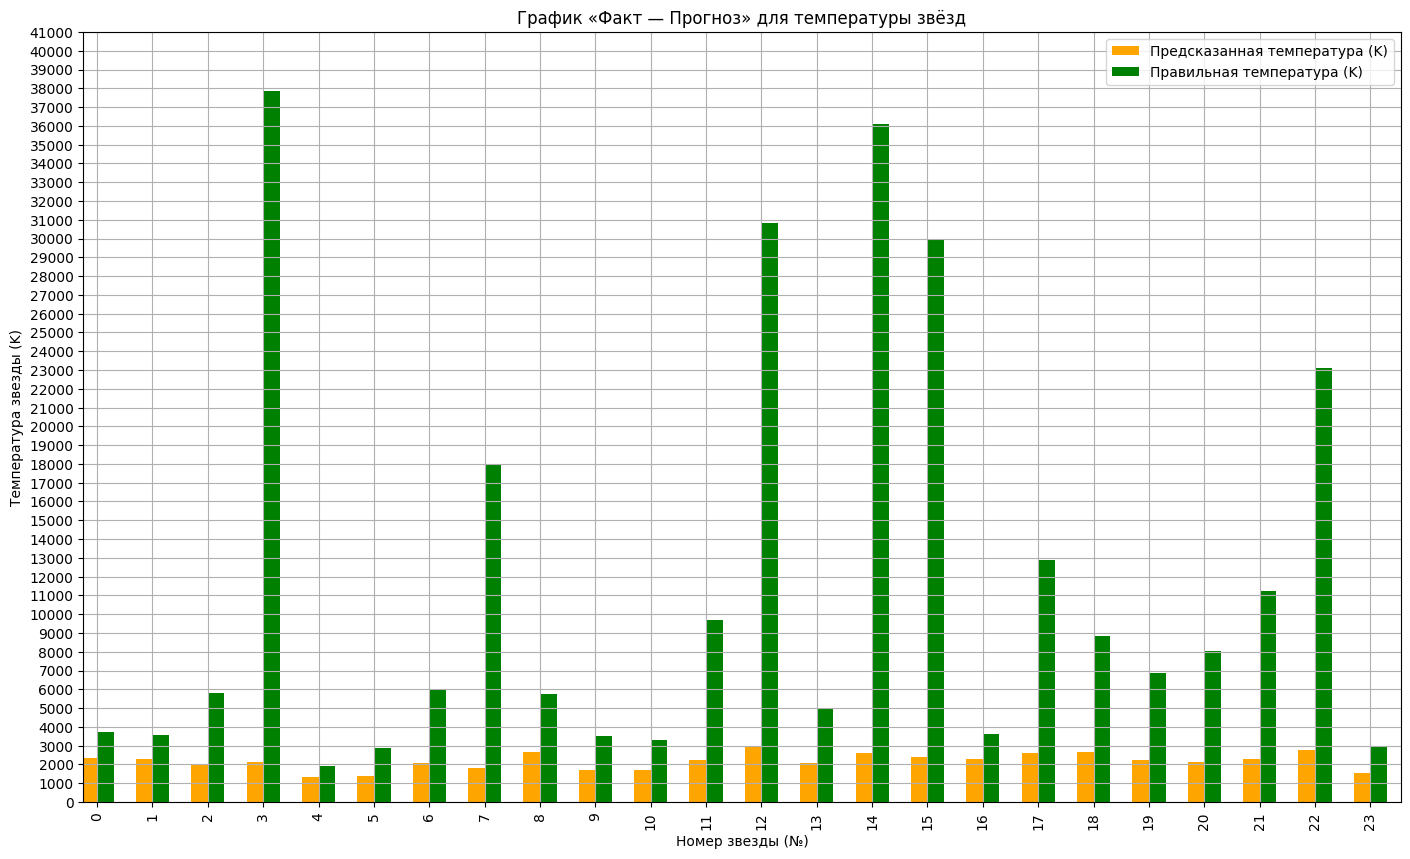

In [78]:
plot_fact_pred(pred_fact_df)

#### Шаг 4.6 Сделайте вывод.

- сеть без скрытых слоёв выглядит бесполезной для нашей задачи, поскольку уменьшения RMSE не происходит - она отсаётся на уровне `~15000 K`;

- сеть с одним скрытым слоем показывает более обнадёживающие результаты, но ни в конфигурации с `50` нейронами в скрытом слое, ни в конфигурации с `200` нейронами в скрытом слое она не оказалась способна достичь RMSE меньше, чем `5000 K`;

- сеть с двумя скрытыми слоями оказалась способна преодолеть отметку в `5000 K` по RMSE, но не очень значительно. При этом наилучшие результаты показывает конфигурация с двумя скрытыми слоями по `50` нейронов в каждом. Что касается конфигцрации с `200` и `500` нейронами в скрытых слоях, то для них наблюдаются признаки, похожие на переобучение - показатели RMSE со временем начинают увиличиваться вместо того уменьшения, которое наблюдалось на более ранних эпохах обучения.

Что касается графика выше, то можно увидеть, что ошибки в основном наблюдаются для звёзд высоких температур - выше `10 000 K`.

<a id='explanation'></a>

В качестве <u>Baseline выберем архитектуру сети с двумя скрытыми слоями по `500` нейронов в каждом - <b>"2 hidden, 500 neurons"</b></u>. Выбор сделаем исходя из того, что далее мы попробуем улучшить данный Baseline методами регуляризации, поэтому, вероятно, имеет смысл выбрать сеть с некоторым простором для регуляризации. В нашем случае конфигурация "2 hidden, 500 neurons" выглядит наиболее подходящим кандидатом для последующего улучшения средствами регуляризации.

### Шаг 5. Улучшение сети
#### Шаг 5.1 Создайте решение с перебором параметров нейросети. Список параметров для перебора должен включать как минимум «dropout» и «размер батча». Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставьте как в Baseline, чтобы сравнить результат.

Добавим регуляризацию посредством техник Dropout и Batch Normalization, также будем перебирать размер батча:

In [79]:
NUM_SAMPLED_CONFIG_ITERS = 3

BATCH_SIZES = [-1, 2, 4, 8]

def set_dropout_and_batch_norm(hidden_layer):
    hidden_layer['dropout_prob'] = round(np.random.uniform(0, 1), 3)
    hidden_layer['do_batch_norm'] = random.choice([True, False])
    return hidden_layer

start_time = time.time()

for i in range(NUM_SAMPLED_CONFIG_ITERS):
    random_batch_size = random.choice(BATCH_SIZES)
    
    hidden1 = { 'hidden_layer_neurons': 300, 'layer_activation': nn.Tanh() }
    hidden1 = set_dropout_and_batch_norm(hidden1)
    
    hidden2 = { 'hidden_layer_neurons': 300, 'layer_activation': nn.ReLU() }
    hidden2 = set_dropout_and_batch_norm(hidden2)
    
    p1  = hidden1['dropout_prob']
    bn1 = hidden1['do_batch_norm']
    p2  = hidden2['dropout_prob']
    bn2 = hidden2['do_batch_norm']
    
    config = [hidden1, hidden2]
    config_name=f'{len(config)} hidden, {config[0]["hidden_layer_neurons"]} neurons & {config[1]["hidden_layer_neurons"]} neurons, p1={p1}, batch_norm1={bn1}, p2={p2}, batch_norm2={bn2}'
    tuned_net = StarTemperatureNet(config, config_name)

    train_neural_net(tuned_net, X_train, y_train, X_valid, y_valid, batch_size=random_batch_size, num_epochs=BASELINE_NUM_EPOCHS)
    
print(f'Time: {round((time.time() - start_time), 3)} seconds')

Neural network "2 hidden, 300 neurons & 300 neurons, p1=0.096, batch_norm1=False, p2=0.956, batch_norm2=False", batch_size=8, num_epochs=150 : training network started...
    RMSE on validation after 50 epochs = 8156.7
    RMSE on validation after 100 epochs = 5978.7
    RMSE on validation after 149 epochs = 5509.0
Neural network "2 hidden, 300 neurons & 300 neurons, p1=0.096, batch_norm1=False, p2=0.956, batch_norm2=False", batch_size=8, num_epochs=150 : training finished!
----------------------------------------------------------------------------------------
Neural network "2 hidden, 300 neurons & 300 neurons, p1=0.448, batch_norm1=True, p2=0.911, batch_norm2=True", batch_size=8, num_epochs=150 : training network started...
    RMSE on validation after 50 epochs = 13933.2
    RMSE on validation after 100 epochs = 4438.2
    RMSE on validation after 149 epochs = 3578.3
Neural network "2 hidden, 300 neurons & 300 neurons, p1=0.448, batch_norm1=True, p2=0.911, batch_norm2=True", batch_

#### Шаг 5.2 Проведите обучение нейронной сети. Выведите метрику RMSE и график «Факт — прогноз». Метрика RMSE не должна превышать 4500.

Neural network "2 hidden, 300 neurons & 300 neurons, p1=0.981, batch_norm1=True, p2=0.307, batch_norm2=True", batch_size=2, num_epochs=150 : training network started...
Neural network "2 hidden, 300 neurons & 300 neurons, p1=0.981, batch_norm1=True, p2=0.307, batch_norm2=True", batch_size=2, num_epochs=150 : training finished!
----------------------------------------------------------------------------------------
Final RMSE on test set: 4455.28759765625 K


,pred,fact
0,3862.455078,3750.0
1,4102.605957,3570.0
2,5226.580078,5800.0
3,26619.572266,37882.0
4,3075.541016,1939.0


,pred,fact
19,3944.043701,6850.0
20,4243.233887,8052.0
21,17513.058594,11250.0
22,19687.966797,23095.0
23,3155.301025,2983.0


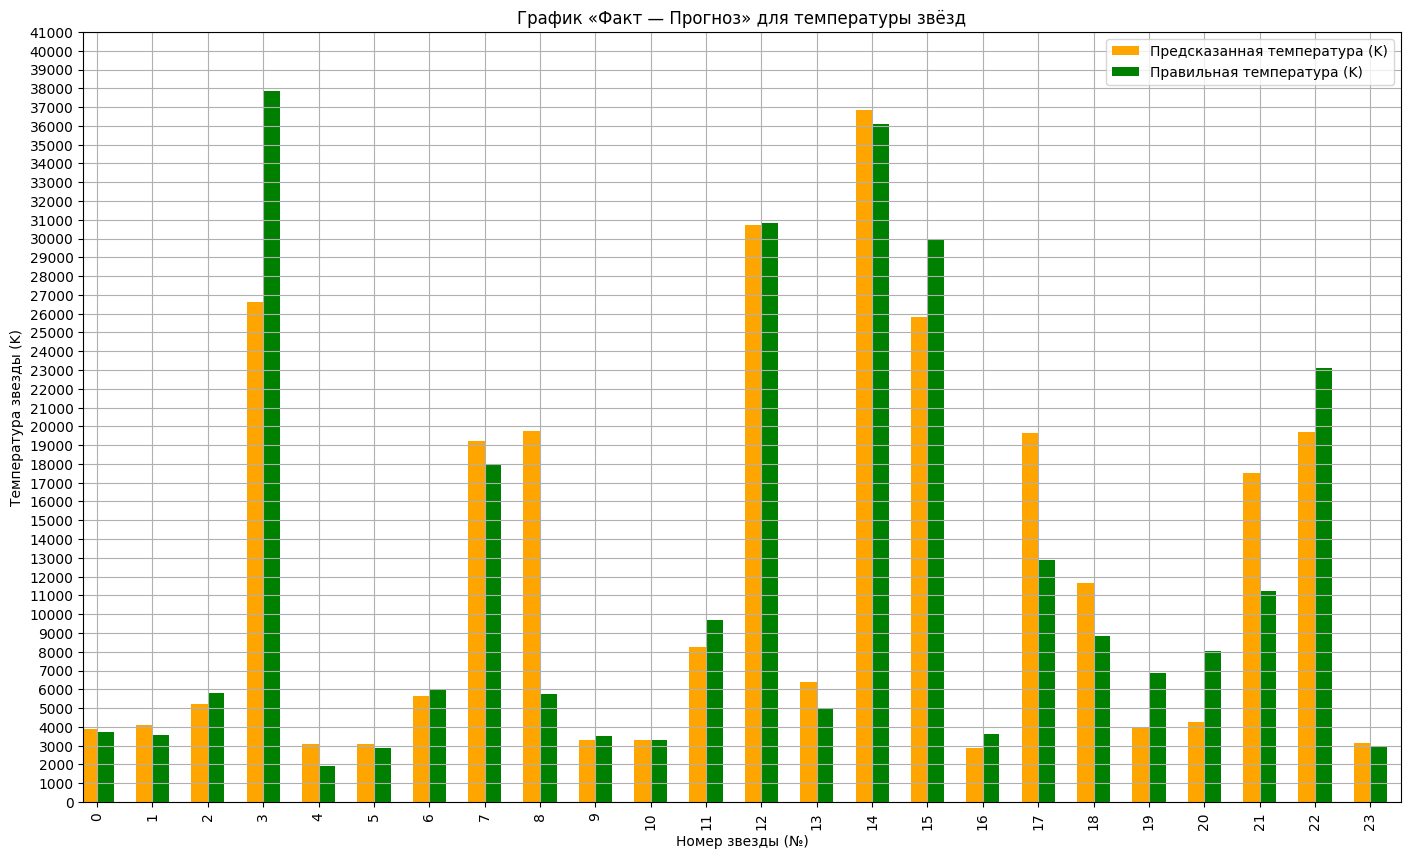

In [80]:
FINAL_BATCH_SIZE = 2
FINAL_NUM_EPOCHS = 150

final_config = [
    { 'hidden_layer_neurons': 300, 'layer_activation': nn.Tanh(), 'dropout_prob': 0.981, 'do_batch_norm': True },
    { 'hidden_layer_neurons': 300, 'layer_activation': nn.ReLU(), 'dropout_prob': 0.307, 'do_batch_norm': True }
]

final_config_name = f'{len(final_config)} hidden, {final_config[0]["hidden_layer_neurons"]} neurons &\
 {final_config[1]["hidden_layer_neurons"]} neurons,\
 p1={final_config[0]["dropout_prob"]},\
 batch_norm1={final_config[0]["do_batch_norm"]},\
 p2={final_config[1]["dropout_prob"]},\
 batch_norm2={final_config[1]["do_batch_norm"]}'

final_net = StarTemperatureNet(final_config, final_config_name)
final_net.eval()
train_neural_net(final_net, X_train_valid, y_train_valid, x_testing=None, y_testing=None, batch_size=FINAL_BATCH_SIZE, num_epochs=FINAL_NUM_EPOCHS)

with torch.inference_mode():
    final_test_preds = final_net.forward(X_test)
    
    final_rmse_value = RMSE(final_test_preds, y_test)
    print(f'Final RMSE on test set: {final_rmse_value} K')

    y_pred = final_test_preds.detach().numpy().flatten()
    pred_fact_df = pd.DataFrame({'pred': y_pred, 'fact': y_test.detach().numpy().flatten()})
    display(pred_fact_df.head())
    display(pred_fact_df.tail())

    plot_fact_pred(pred_fact_df)

#### Шаг 5.3 Сделайте вывод. Желательно оформить его в виде таблицы или графика.

In [81]:
baseline_vs_final_df = pd.DataFrame(
    data={'Значение RMSE': [round(baseline_rmse_value.item(), 3), round(final_rmse_value.item(), 3)]},
    index=['Baseline RMSE', 'Final RMSE'])
display(baseline_vs_final_df)

,Значение RMSE
Baseline RMSE,14457.256
Final RMSE,4455.288


### Шаг 6. Выводы по проекту
#### Шаг 6.1 Кратко опишите результаты каждого типа модели.

- Baseline-нейросеть продемонстрировала качество в `14589 K`, для её получения была выбрана сеть с 2 скрытыми слоями по `300` нейронов в каждом. Обучение производилось без использования батчей и без регуляризации на `150` эпохах. График факт-прогноз показывает, что модель оказалась не способна предсказывать температуры выше `3000 К`.

- Final-нейросеть была сконфигурирована аналогичным образом, за исключением добавления Dropout-регуляризации в оба слоя и батч-нормализации также после обоих скрытых слоёв. График факт-прогноз выглядит значительно более правдоподобным, за исключением `3` и `8` звёзд тестового набора, где наблюдается очень большое расхождение между фактической и спрогнозированной температурой.

#### Шаг 6.2 Напишите выводы сравнения двух моделей.

Финальная модель продемонстрировала более значительно более высокое качество, которое, тем не менее, лишь незначительно превосходит целевой показатель в `4500 K`. Здесь, судя по всему, повлияло сильное использование регуляризации - в первую очередь, Dropout в первом скрытом слое с параметров `p1=0.981`. Также в финальной модели был использован батчинг со значением `batch_size`, что могло положительно повлиять на качество модели.